In [1]:
import os

import numpy as np
import pandas as pd

from shapely.geometry import LineString
from shapely.geometry import Point, MultiPoint, MultiLineString
from shapely.ops import linemerge, nearest_points

import geopandas as gpd
from geopandas import GeoDataFrame
from centerline.geometry import Centerline

from tqdm.notebook import tqdm_notebook
tqdm_notebook.pandas()

In [127]:
cDir = os.getcwd()
print(cDir)
df = gpd.read_file(cDir+"/Sidewalks/NewSidewalks2.shp")

C:\Users\mtholden\Documents\Projects\Sidewalks


In [128]:
crs = {'init': 'epsg:6487'}
df.crs

{'init': 'epsg:6487'}

In [129]:
print(len(df))

15529


In [130]:
df.simplify(1)

0        POLYGON ((402246.503 140304.048, 402246.617 14...
1        POLYGON ((400693.417 137190.004, 400691.742 13...
2        POLYGON ((401128.236 139372.106, 401128.225 13...
3        POLYGON ((402511.834 138873.900, 402508.143 13...
4        POLYGON ((401063.040 137985.231, 401064.701 13...
                               ...                        
15524    POLYGON ((393510.587 140824.763, 393509.872 14...
15525    POLYGON ((400279.190 141438.190, 400358.606 14...
15526    POLYGON ((399287.207 134702.830, 399298.829 13...
15527    POLYGON ((399665.462 134810.868, 399663.510 13...
15528    POLYGON ((400308.122 138017.569, 400307.182 13...
Length: 15529, dtype: geometry

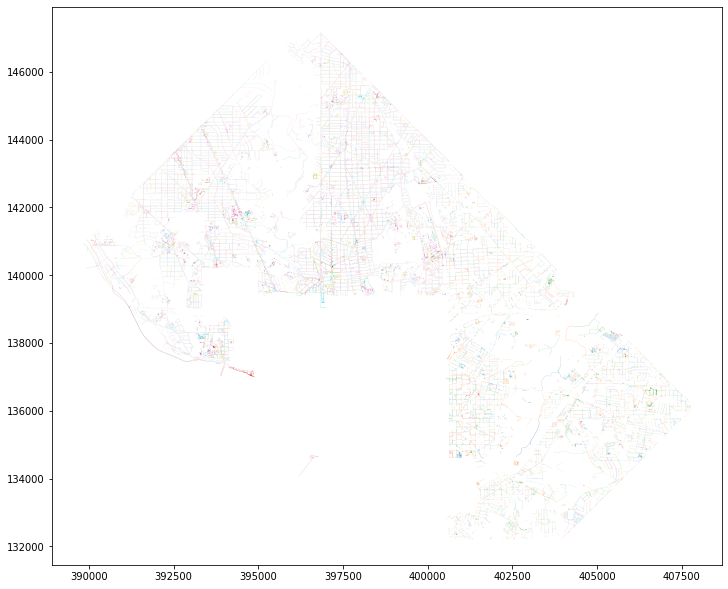

In [131]:
df.plot(figsize=(12, 12), cmap='tab10')

In [132]:
df_dissolved = gpd.GeoDataFrame(geometry=gpd.GeoSeries([geom for geom in df.unary_union.geoms]))

In [133]:
print(len(df_dissolved))

14895


In [134]:
df_exploded = gpd.GeoDataFrame(df_dissolved.geometry.explode())

In [135]:
print(len(df_exploded))

14895


In [136]:
#df_exploded.plot(figsize=(12, 12), cmap='tab10')

In [137]:
def augment(x):
    try:
        test = Centerline(x, interpolation_distance=0.15)
        return(test)
    except:
        return(LineString([(0, 0), (0.1, 0.1)]))
        

In [138]:
df_exploded['centerlines'] = df_exploded.progress_apply(lambda row: augment(row.geometry), axis=1)

In [139]:
df_exploded = df_exploded.set_geometry('centerlines')

In [140]:
df_exploded.head()

,,geometry,centerlines
0,0,"POLYGON ((402545.180 132232.571, 402545.208 13...","MULTILINESTRING ((402535.889 132222.744, 40253..."
1,0,"POLYGON ((402351.984 132212.129, 402349.828 13...","MULTILINESTRING ((402324.238 132235.210, 40232..."
2,0,"POLYGON ((402636.288 132926.812, 402636.890 13...","MULTILINESTRING ((402724.494 132878.317, 40272..."
3,0,"POLYGON ((401669.394 134384.712, 401670.586 13...","MULTILINESTRING ((401577.811 134354.595, 40157..."
4,0,"POLYGON ((404808.014 133501.189, 404805.933 13...","MULTILINESTRING ((404573.966 133399.792, 40457..."


In [141]:
dfNoZero = df_exploded.length>0.141422
dfGreater = df_exploded[dfNoZero]

In [142]:
dfGreater = df_exploded[dfNoZero]

In [143]:
dfGreater.head()

,,geometry,centerlines
0,0,"POLYGON ((402545.180 132232.571, 402545.208 13...","MULTILINESTRING ((402535.889 132222.744, 40253..."
1,0,"POLYGON ((402351.984 132212.129, 402349.828 13...","MULTILINESTRING ((402324.238 132235.210, 40232..."
2,0,"POLYGON ((402636.288 132926.812, 402636.890 13...","MULTILINESTRING ((402724.494 132878.317, 40272..."
3,0,"POLYGON ((401669.394 134384.712, 401670.586 13...","MULTILINESTRING ((401577.811 134354.595, 40157..."
4,0,"POLYGON ((404808.014 133501.189, 404805.933 13...","MULTILINESTRING ((404573.966 133399.792, 40457..."


In [144]:
dfGreater['centerlines'] = dfGreater['centerlines'].progress_apply(linemerge)

In [145]:
def remove_short_lines(line):
    
    if line.type == 'MultiLineString':
        
        passing_lines = []
    
        for i, linestring in enumerate(line):
            
            other_lines = MultiLineString([x for j, x in enumerate(line) if j != i])
            
            p0 = Point(linestring.coords[0])
            p1 = Point(linestring.coords[-1])
            
            is_deadend = False
            
            if p0.disjoint(other_lines): is_deadend = True
            if p1.disjoint(other_lines): is_deadend = True
            
            if not is_deadend or linestring.length > 5:                
                passing_lines.append(linestring)
            
        return MultiLineString(passing_lines)
            
    if line.type == 'LineString':
        return line

In [146]:
dfGreater['centerlines'] = dfGreater['centerlines'].progress_apply(remove_short_lines)

In [147]:
dfGreater.head(1)

,,geometry,centerlines
0,0,"POLYGON ((402545.180 132232.571, 402545.208 13...","MULTILINESTRING ((402537.023 132226.227, 40253..."


In [148]:
dfGreater['centerlines'] = dfGreater['centerlines'].progress_apply(lambda row: row.simplify(1, preserve_topology=True))

In [149]:
def linestring_to_segments(linestring):
    return [LineString([linestring.coords[i], linestring.coords[i+1]]) for i in range(len(linestring.coords) - 1)]

In [150]:
def get_segments(line):
    
    line_segments = []

    if line.type == 'MultiLineString':
        
        for linestring in line.geoms:
            
            line_segments.extend(linestring_to_segments(linestring))

    if line.type == 'LineString':
        
        line_segments.extend(linestring_to_segments(line))

    return line_segments

In [151]:
dfGreater.head(1)

,,geometry,centerlines
0,0,"POLYGON ((402545.180 132232.571, 402545.208 13...","MULTILINESTRING ((402537.023 132226.227, 40253..."


In [152]:
dfGreater['segments'] = dfGreater['centerlines'].progress_apply(get_segments)
dfGreater.head(1)

,,geometry,centerlines,segments
0,0,"POLYGON ((402545.180 132232.571, 402545.208 13...","MULTILINESTRING ((402537.023 132226.227, 40253...",[LINESTRING (402537.0231268346 132226.22675336...


In [153]:
def interpolate_by_distance(linestring):
    
    distance = 1
    all_points = []
    count = round(linestring.length / distance) + 1
    
    if count == 1:
        all_points.append(linestring.interpolate(linestring.length / 2))
    
    else:
        for i in range(count):
            all_points.append(linestring.interpolate(distance * i))
    
    return all_points

def interpolate(line):
    
    if line.type == 'MultiLineString':
        
        all_points = []
        
        for linestring in line:
            all_points.extend(interpolate_by_distance(linestring))
        
        return MultiPoint(all_points)
            
    if line.type == 'LineString':
        return MultiPoint(interpolate_by_distance(line))
    
    
def polygon_to_multilinestring(polygon):

    return MultiLineString([polygon.exterior] + [line for line in polygon.interiors])
    

def get_avg_distances(row):
    
    avg_distances = []
    
    sidewalk_lines = polygon_to_multilinestring(row.geometry)
    
    for segment in row.segments:
        
        points = interpolate(segment)
        
        distances = []
        
        for point in points:
            p1, p2 = nearest_points(sidewalk_lines, point)
            distances.append(p1.distance(p2))
            
        avg_distances.append(sum(distances) / len(distances))
        
    return avg_distances

In [154]:
dfGreater['avg_distances'] = dfGreater.progress_apply(lambda row: get_avg_distances(row), axis=1)
dfGreater.head(1)

,,geometry,centerlines,segments,avg_distances
0,0,"POLYGON ((402545.180 132232.571, 402545.208 13...","MULTILINESTRING ((402537.023 132226.227, 40253...",[LINESTRING (402537.0231268346 132226.22675336...,"[2.1910953118812166, 2.5841632918602064, 3.063..."


In [155]:
data = {'geometry': [], 'width': []}

for i, row in dfGreater.iterrows():
    
    for segment in row.segments:
        data['geometry'].append(segment)
    
    for distance in row.avg_distances:
        data['width'].append(distance * 2)
        
df_segments = pd.DataFrame(data)
df_segments = GeoDataFrame(df_segments, crs=crs, geometry='geometry')
df_segments.head(1)

,geometry,width
0,"LINESTRING (402537.023 132226.227, 402536.827 ...",4.382191


In [156]:
df_segments['width'] = df_segments['width'] * 3.28084

In [157]:
df_segments['width'] = round(df_segments['width'] * 10) / 10
df_segments.head()

,geometry,width
0,"LINESTRING (402537.023 132226.227, 402536.827 ...",14.4
1,"LINESTRING (402536.850 132224.480, 402536.827 ...",17.0
2,"LINESTRING (402536.850 132224.480, 402537.495 ...",20.1
3,"LINESTRING (402537.924 132222.550, 402537.495 ...",23.2
4,"LINESTRING (402537.924 132222.550, 402538.710 ...",24.8


In [158]:
df_segments.crs

{'init': 'epsg:6487'}

In [159]:
df_projected = df_segments.to_crs('EPSG:4326')
df_projected.crs

C:\Program Files\ArcGIS\Pro\bin\Python\envs\geoTest\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


'EPSG:4326'

In [160]:
with open('DC_Sidewalks2.geojson', 'w') as f:
    f.write(df_projected.to_json())

In [161]:
df_dc1 = gpd.read_file('DC_Sidewalks1.geojson')
df_dc2 = gpd.read_file('DC_Sidewalks2.geojson')

In [163]:
df_both = gpd.GeoDataFrame(pd.concat([df_dc1,df_dc2],ignore_index=True))

In [176]:
df_both.head()

,id,width,geometry
0,0,6.3,"LINESTRING (-77.01897 38.82057, -77.01896 38.8..."
1,1,8.6,"LINESTRING (-77.01891 38.82030, -77.01896 38.8..."
2,2,5.2,"LINESTRING (-77.01896 38.82034, -77.01897 38.8..."
3,3,7.2,"LINESTRING (-77.01891 38.82030, -77.01889 38.8..."
4,4,12.0,"LINESTRING (-77.01886 38.82026, -77.01891 38.8..."


In [165]:
with open('dc_sidewalksAll.geojson','w') as f:
    f.write(df_both.to_json())

In [175]:
df_both['geometry'] = np.round(np.array(df_both['geometry']),5)

TypeError: unsupported operand type(s) for *: 'LineString' and 'float'

In [171]:
#dcSimp['geometry'] = np.round(np.array(dcSimp['geometry']),5)
dcSimp.head()

0    LINESTRING (-77.01897 38.82057, -77.01896 38.8...
1    LINESTRING (-77.01891 38.82030, -77.01896 38.8...
2    LINESTRING (-77.01896 38.82034, -77.01897 38.8...
3    LINESTRING (-77.01891 38.82030, -77.01889 38.8...
4    LINESTRING (-77.01886 38.82026, -77.01891 38.8...
dtype: geometry

In [ ]:
with open('dcSimp2.geojson','w') as f:
    f.write(dcSimp.to_json())

In [177]:
df_both.to_file("dcSidewalkscenter.shp")

In [178]:
print(len(df_both))

653619


In [183]:
dfsmall = df_both.length>1
dfbig = df_both[dfsmall]

In [184]:
print(len(dfbig))

0


In [187]:
dcBigger = gpd.read_file("SidewalkWidthEvenBigger.shp")

In [188]:
with open('DC_SidewalkWidth.geojson','w') as f:
    f.write(dcBigger.to_json())

In [189]:
dccheck = gpd.read_file('DC_SidewalkWidth.geojson')

In [190]:
dccheck.crs

{'init': 'epsg:4326'}

In [191]:
dcProject = dccheck.to_crs('EPSG:3395')
dcProject.crs

C:\Program Files\ArcGIS\Pro\bin\Python\envs\geoTest\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


'EPSG:3395'

In [192]:
with open('DC_SidewalkWidthProject.geojson','w') as f:
    f.write(dcProject.to_json())